In [1]:
# imports and setting up file IO

import datetime
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from vis.visualization import visualize_cam 

training_data_path = r"D:\HerniaModelStudy\5LayerTrainingCrop"
testing_data_path = r"D:\HerniaModelStudy\LayerTesting2Crop"
validation_data_path = r"D:\HerniaModelStudy\LayerTesting2"
second_validation_data_path = r"D:\HerniaModelStudy\LayerTesting"

model_to_validate_path = r"D:\HerniaModelStudy\SavedModels\model_2019-07-31_10-56-08.h5"

model_save_path = r"D:\HerniaModelStudy\SavedModels"
notebook_save_path = r"D:\HerniaModelStudy\SavedNotebooks"

train_model = True

classes = ['None', 'Skin', 'Fat', 'Extob', 'Spchd', 'Sack']
classes = ['Extob', 'Fat', 'None', 'Sack', 'Skin', 'Spchd']

resized_image_size = 64

if not os.path.exists(training_data_path):
    print("Could not find folder: " + training_data_path)
    raise

if not os.path.exists(testing_data_path):
    print("Could not find folder: {}".format(testing_data_path))
    raise
    
if not os.path.exists(validation_data_path):
    print("Could not find folder: {}".format(validation_data_path))
    raise
    
if not os.path.exists(second_validation_data_path):
    print("Could not find folder: {}".format(second_validation_data_path))
    raise


Using TensorFlow backend.


In [2]:
# prepare data for generators and split to training and test and validation

from sklearn.model_selection import train_test_split

training_globs = []
testing_globs = []
validation_globs = []
second_validation_globs = []

num_classes = len(classes)

print("Number of classes: {}".format(num_classes))

for i in range(num_classes):
    training_class_path = os.path.join(training_data_path, classes[i])
    testing_class_path = os.path.join(testing_data_path, classes[i])
    validation_class_path = os.path.join(validation_data_path, classes[i])
    second_validation_class_path = os.path.join(second_validation_data_path, classes[i])
    
    training_class_glob = glob(os.path.join(training_class_path, "*.png"))
    testing_class_glob = glob(os.path.join(testing_class_path, "*.png"))
    validation_class_glob = glob(os.path.join(validation_class_path, "*.png"))
    second_validation_class_glob = glob(os.path.join(second_validation_class_path, "*.png"))
    
    training_globs.append(training_class_glob)
    testing_globs.append(testing_class_glob)
    validation_globs.append(validation_class_glob)
    second_validation_globs.append(second_validation_class_glob)

Number of classes: 6


[[[120  89  79]
  [118  88  78]
  [119  86  77]
  ...
  [202 151 116]
  [201 151 120]
  [201 151 120]]

 [[121  91  80]
  [118  88  78]
  [119  86  77]
  ...
  [202 151 116]
  [201 151 120]
  [201 151 120]]

 [[124  91  81]
  [120  87  78]
  [119  86  77]
  ...
  [199 153 116]
  [199 152 120]
  [199 152 120]]

 ...

 [[203 154 122]
  [203 154 122]
  [203 154 118]
  ...
  [203 159 133]
  [203 160 131]
  [203 160 131]]

 [[203 154 118]
  [203 154 118]
  [203 155 114]
  ...
  [203 159 133]
  [203 160 131]
  [203 160 131]]

 [[202 153 117]
  [202 153 117]
  [203 155 114]
  ...
  [204 161 134]
  [204 161 132]
  [204 161 132]]]
[[[174  99  81]
  [175 100  82]
  [175  98  81]
  ...
  [193 154 113]
  [194 151 108]
  [195 152 110]]

 [[175 100  82]
  [174  99  81]
  [174  97  80]
  ...
  [192 153 112]
  [194 151 108]
  [195 152 110]]

 [[175 100  82]
  [173  98  80]
  [173  98  80]
  ...
  [190 154 112]
  [194 152 112]
  [195 154 113]]

 ...

 [[158 117  92]
  [160 118  93]
  [161 118  91]
  ..

[[[154 121 102]
  [153 120 101]
  [153 120 101]
  ...
  [180 139 116]
  [182 138 116]
  [183 139 117]]

 [[153 120 101]
  [152 118 100]
  [152 118 100]
  ...
  [179 137 115]
  [181 137 115]
  [182 138 116]]

 [[153 120 101]
  [153 120 101]
  [155 119 101]
  ...
  [182 139 110]
  [182 138 112]
  [182 138 112]]

 ...

 [[189 141 114]
  [189 141 114]
  [189 141 112]
  ...
  [188 151 113]
  [187 149 118]
  [187 149 118]]

 [[189 142 106]
  [189 142 106]
  [189 142 106]
  ...
  [189 151 123]
  [188 149 121]
  [187 148 120]]

 [[189 142 106]
  [189 142 106]
  [189 142 106]
  ...
  [190 152 124]
  [189 151 123]
  [188 149 121]]]
[[[152 120 105]
  [150 118 104]
  [150 118 104]
  ...
  [167 131  98]
  [168 132 101]
  [169 133 102]]

 [[152 120 105]
  [150 118 104]
  [150 118 104]
  ...
  [167 131  98]
  [168 132 101]
  [168 132 101]]

 [[152 120 105]
  [150 118 104]
  [152 120 105]
  ...
  [168 132 101]
  [170 131 103]
  [170 131 103]]

 ...

 [[255  79  48]
  [255  76  46]
  [255  73  48]
  ..

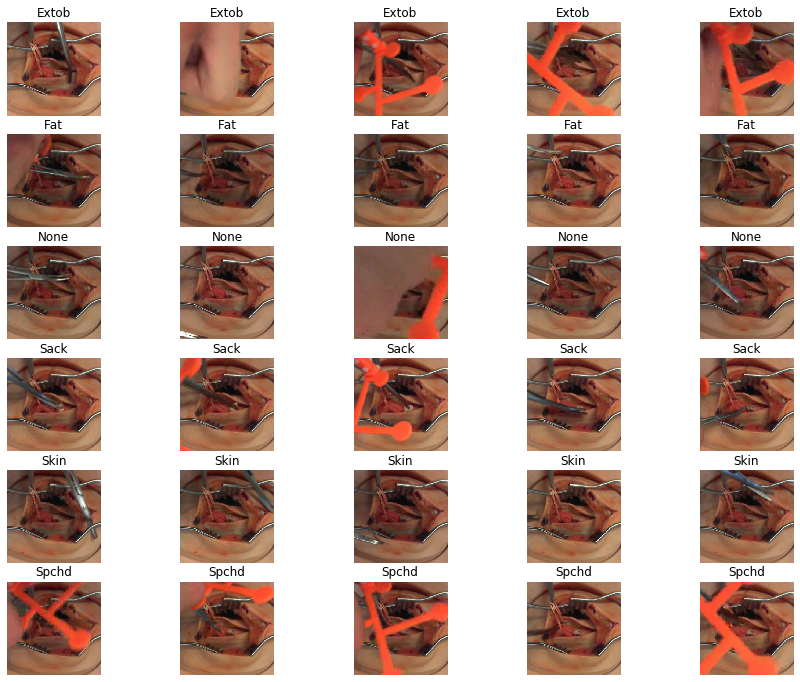

In [5]:
# Show sample images of all classes

num_choices = 5
random_choices = []
labels = []

for i in range(num_classes):
    random_choice = np.random.choice(training_globs[i], num_choices)
    random_choices.append(random_choice)
    labels.append(num_choices * [classes[i]])

plt.figure(figsize=(3*num_choices,2*num_classes))

for class_index in range(num_classes):
    for choice_index in range(num_choices):
        im = Image.open(random_choices[class_index][choice_index]).convert('RGB')
        plt.subplot(num_classes, num_choices, class_index * num_choices + choice_index + 1)
        plt.title(labels[class_index][choice_index])
        plt.imshow(np.asarray(im))
        print(np.asarray(im))
        plt.axis('off')

In [55]:
# set up the data generators for train, test, validation. 

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

second_valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    testing_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    validation_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

second_valid_generator = second_valid_datagen.flow_from_directory(
    second_validation_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 18683 images belonging to 6 classes.
Found 1386 images belonging to 6 classes.
Found 1385 images belonging to 6 classes.
Found 1386 images belonging to 6 classes.


In [56]:
# define the model

def HappyModel():
    X_input = Input(shape = (resized_image_size, resized_image_size, 3), name = 'X_input')
 
    X = Conv2D(8, (3, 3), strides = (1,1) , padding = 'valid')(X_input)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Conv2D(16, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = Conv2D(32, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
    
    X = Conv2D(64, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = Conv2D(128, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Flatten()(X)

    X = Dense(num_classes * 8 + 20, input_shape = (29 * 29 * 16, 1))(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
 
    X = Dense(num_classes * 4 + 10)(X)
    X = Activation('relu')(X)
 
    X = Dense(num_classes)(X)
    X = Activation('softmax')(X)
    
    return Model([X_input], [X])

if train_model:
    model = HappyModel()
else:
    model = load_model(model_to_validate_path)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 16)        1168      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
__________

In [57]:
# train the model

if train_model:
    num_epochs = 10
    steps_per_epoch = int(train_generator.n / batch_size)
    validation_steps = int(test_generator.n / batch_size)

    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    training_time_start = datetime.datetime.now()

    history = model.fit_generator(
        train_generator,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_generator,
        validation_steps=validation_steps)
else:
    print("Training skipped, using loaded model. ")

Epoch 1/10
583/583 [==============================] - 46s 79ms/step - loss: 1.4400 - acc: 0.3827 - val_loss: 2.6587 - val_acc: 0.1882
Epoch 2/10
583/583 [==============================] - 45s 77ms/step - loss: 0.9649 - acc: 0.5849 - val_loss: 4.6343 - val_acc: 0.1588
Epoch 3/10
583/583 [==============================] - 44s 76ms/step - loss: 0.7599 - acc: 0.6873 - val_loss: 5.0268 - val_acc: 0.2024
Epoch 4/10
583/583 [==============================] - 45s 77ms/step - loss: 0.6651 - acc: 0.7304 - val_loss: 4.5880 - val_acc: 0.2112
Epoch 5/10
583/583 [==============================] - 45s 76ms/step - loss: 0.6012 - acc: 0.7599 - val_loss: 5.0939 - val_acc: 0.2253
Epoch 6/10
583/583 [==============================] - 45s 77ms/step - loss: 0.5579 - acc: 0.7786 - val_loss: 7.7754 - val_acc: 0.1839
Epoch 7/10
583/583 [==============================] - 45s 76ms/step - loss: 0.5295 - acc: 0.7931 - val_loss: 5.2720 - val_acc: 0.2142
Epoch 8/10
583/583 [==============================] - 45s 77ms

In [58]:
# print out time info
if train_model:
    training_time_stop = datetime.datetime.now()
    print("Training started at: {}".format(training_time_start))
    print("Training stopped at: {}".format(training_time_stop))
    print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-08-01 15:59:05.624391
Training stopped at: 2019-08-01 16:06:35.928972
Total training time: 0:07:30.304581


In [59]:
#print(history)

In [60]:
# get the loss and accuracy of the model on the validation set
#results = model.evaluate_generator(valid_generator, len(valid_generator))
results = model.evaluate_generator(valid_generator, 100)
print(model.metrics_names)
print(results)

['loss', 'acc']
[5.755902619171384, 0.2013316423659961]


In [61]:
# get the loss and accuracy of the model on the second validation set
second_results = model.evaluate_generator(second_valid_generator, len(second_valid_generator))
print(model.metrics_names)
print(second_results)

['loss', 'acc']
[6.044759473759375, 0.17171717172792292]


In [62]:
valid_generator.reset()
total = 0
correct = 0
while total< 10000:
    try:
        x, y = valid_generator.next()
    except:
        break

    pred = model.predict(x)
    pred1 = np.argmax(pred, axis=1)
    pred2 = np.zeros((pred1.shape[0], 6))
    try:
        pred2[np.arange(pred1.shape[0]), pred1] = 1
    except IndexError:
        print("Uh Oh")
        print(pred1.shape[0])
        print(pred2)
        print(pred1)
    #print(pred1)
    #print(pred2)
    #print(y)

    for i in range(pred1.shape[0]):
        #print(pred2[i])
        #print(y[i])
        total+=1
        if np.array_equal(pred2[i], y[i]):
            correct +=1
    print(correct/total)
    
print(total)

# pred = model.predict(x)
# pred1 = np.eye(6)[pred]

# np.argmax(pred, axis=1)
# y


0.1875
0.171875
0.17708333333333334
0.2265625
0.23125
0.203125
0.20535714285714285
0.1953125
0.19791666666666666
0.2
0.19602272727272727
0.203125
0.1971153846153846
0.19642857142857142
0.19791666666666666
0.20703125
0.20772058823529413
0.21006944444444445
0.21217105263157895
0.2140625
0.20982142857142858
0.21164772727272727
0.20652173913043478
0.203125
0.205
0.20673076923076922
0.20717592592592593
0.20870535714285715
0.20474137931034483
0.20729166666666668
0.2127016129032258
0.208984375
0.21022727272727273
0.2104779411764706
0.20892857142857144
0.2048611111111111
0.20692567567567569
0.20888157894736842
0.20833333333333334
0.20859375
0.21036585365853658
0.21205357142857142
0.20857558139534885
0.20794223826714803
0.20748059280169373
0.2056590752242926
0.20324105334233625
0.2015862524785195
0.2051779935275081
0.20481927710843373
0.2038533250466128
0.2017062766605728
0.20023909145248056
0.20117302052785924
0.20149683362118595
0.20124364047484455
0.20322043309272628
0.20185488270594654
0.20

In [63]:
# make some predictions
predictions = model.predict_generator(valid_generator, 1)
vec_predicts = np.zeros(predictions.shape)
for row in range(vec_predicts.shape[1]):
    vec_predicts[row][np.argmax(predictions[row])] = 1
#vec_predicts
    
    

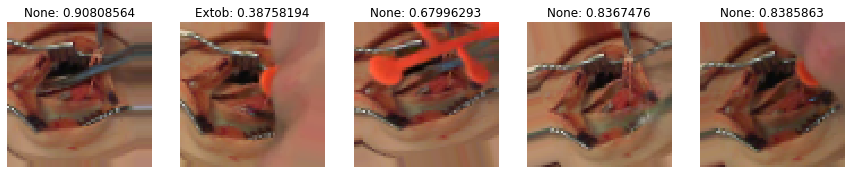

In [64]:
# show some results

test_generator.reset()
x,y = test_generator.next()

num_choices = 5
test_indices = range(batch_size)

random_choice = np.random.choice(test_indices, num_choices)

plt.figure(figsize=(3*num_choices, 3))

for i in range(num_choices):
    im = x[random_choice[i]][:,:,:]
    prediction = model.predict(np.expand_dims(im, 0))
    plt.subplot(1, num_choices, i+1)
    max_index = np.argmax(prediction[0])
    plt.title(str(classes[max_index]) + ": " + str(prediction[0][max_index]))
    plt.imshow((im + 1)/2)
    plt.axis('off')

In [65]:
def plots(ims, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :], cmap='gray')

def cplots(ims, figsize=(20,6), rows=1, titles=None):
    print(np.amax(ims.flatten()))
    m = np.amax(ims.flatten())
    ims = [x / m for x in ims]
    #ims/=np.amax(np.ndarray.flatten(ims))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :])

(5, 64, 64)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
0


C:\Users\jlaframboise\.conda\envs\hernia\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


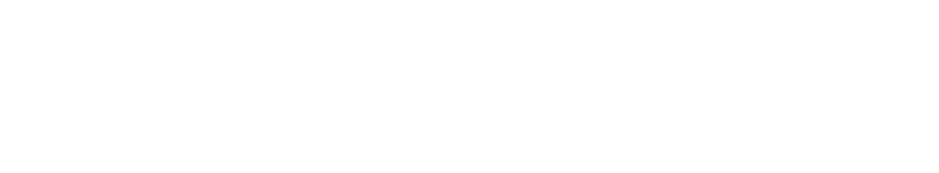

In [66]:
from vis.visualization import visualize_saliency
n_images= 5
start_index = 5
heat_map = np.zeros((n_images, resized_image_size, resized_image_size), dtype = int)
print(heat_map.shape)
test_generator.reset()
for i in range(n_images):
    x, y = test_generator.next()
    heat_map[i][:,:] = visualize_cam(model, 14, None, x[i][:,:,:])
print(heat_map)
#cplots(heat_map[:n_images], figsize=(20,5), rows=1)
cplots(heat_map[:n_images], figsize=(20,5), rows=1)

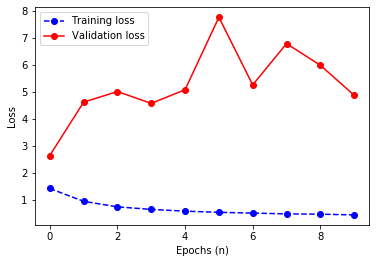

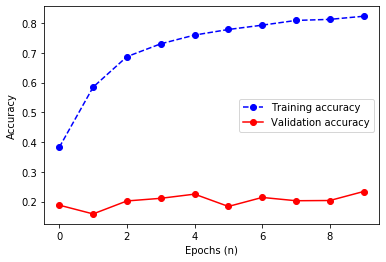

In [67]:
# graphical results

plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(history.history['acc'], 'bo--')
plt.plot(history.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [68]:
# save the results and model
if train_model:
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
        print("Creating folder: {}".format(model_save_path))

    model_file_name = "model_" + timestamp + ".h5"
    model_file_fullname = os.path.join(model_save_path, model_file_name)

    model.save(model_file_fullname)
    print("Model saved to: {}".format(model_file_fullname))

    notebook_file_name = "notebook_" + timestamp + ".html"
    notebook_file_fullpath = os.path.join(notebook_save_path, notebook_file_name)

    if not os.path.exists(notebook_save_path):
        os.makedirs(notebook_save_path)
        print("Creating folder: {}".format(notebook_save_path))

    os.system("jupyter nbconvert --to html TrainHappyModel.ipynb --output " + notebook_file_fullpath)

    print("Notebook saved to: {}".format(notebook_file_fullpath))
else:
    print("Nothing saved becuase model not retrained. ")

Model saved to: D:\HerniaModelStudy\SavedModels\model_2019-08-01_16-08-11.h5
Notebook saved to: D:\HerniaModelStudy\SavedNotebooks\notebook_2019-08-01_16-08-11.html
